Let's start by importing all the libraries we will use.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np
import random
from sklearn import manifold
from scipy.spatial.distance import cdist

And creating a set of data to work with. It's a small set of data where $n=64$ because the implementation of LAP in this notebook isn't very fast.

CPU times: user 135 ms, sys: 10.5 ms, total: 145 ms
Wall time: 145 ms


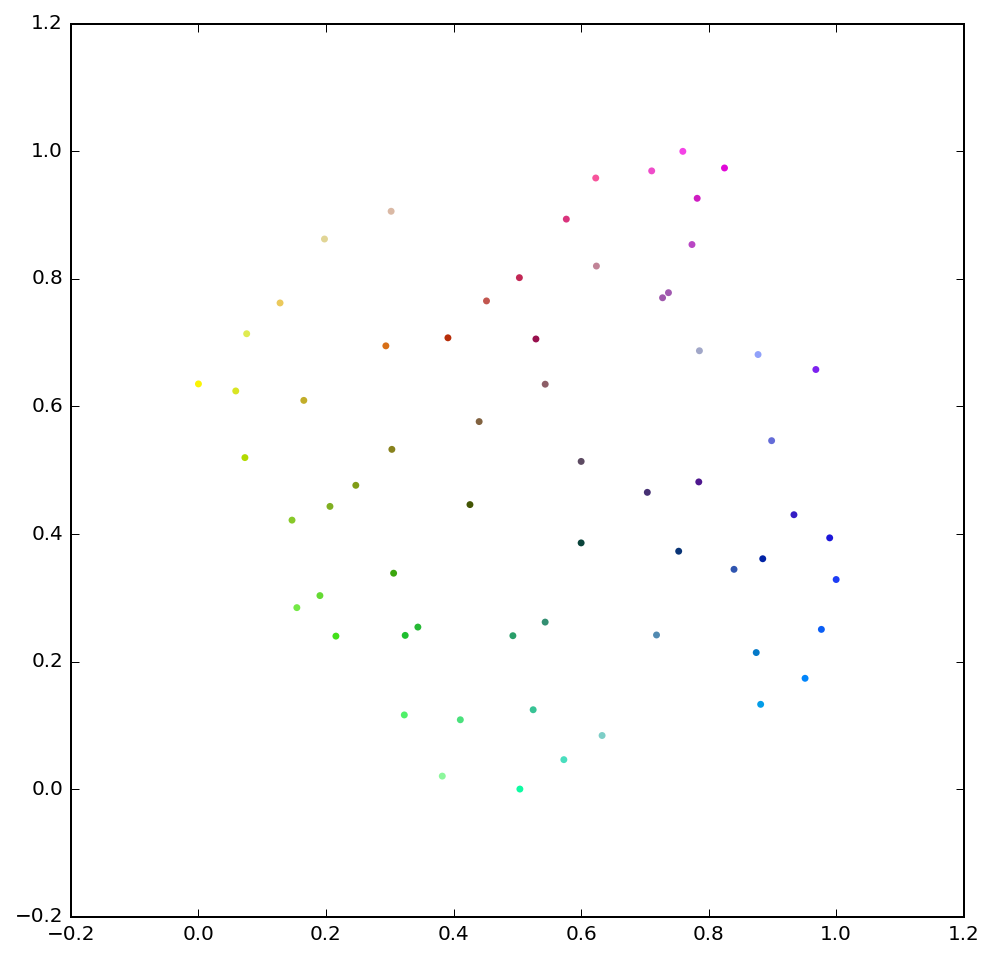

In [2]:
side = 8
totalDataPoints = side * side
data3d = np.random.uniform(low=0.0, high=1.0, size=(totalDataPoints, 3))
tsne = manifold.TSNE(n_components=2, learning_rate=50)
%time data2d = tsne.fit_transform(data3d)
data2d -= data2d.min(axis=0)
data2d /= data2d.max(axis=0)
plt.figure(figsize=(8, 8))
plt.scatter(data2d[:,0], data2d[:,1], c=data3d, edgecolors='none', marker='o', s=12)  
plt.show()

Now comes the bulk of the code, which is a port of the Jonker-Volgenant algorithm, written by Roy Jonker. The big difference with having this code in Python is that when accessing the assignment cost with `assigncost[i,j]`, this can be overloaded by a `numpy.ndarray` or another object that describes a relationship between two sets of items to be matched.

In [3]:
index_dtype = np.intc
cost_dtype = np.float32
BIG = np.float32('inf')

# assigncost is required to implement:
# * __len__(self): which returns the length of one side of the cost matrix
# * __getitem__(self, ij): which takes a pair of indices and returns the cost
# this means that np.ndarray will work, and so will PointCost above
def lap(assigncost):
    """
    input:
        assigncost: square cost matrix
    output:
        rowsol: column assigned to row in solution
        colsol: row assigned to column in solution
        u: dual variables, row reduction numbers
        v: dual variables, column reduction numbers
    """
    
    # COLUMN REDUCTION
    dim = len(assigncost)
    rowsol = np.ndarray(dim, dtype=index_dtype)
    colsol = np.ndarray(dim, dtype=index_dtype)
    u = np.ndarray(dim, dtype=cost_dtype)
    v = np.ndarray(dim, dtype=cost_dtype)
    matches = np.zeros(dim, dtype=index_dtype) # counts how many times a row could be assigned
    
    for j in xrange(dim-1,-1,-1): # reverse order gives better results
        # find minimum cost over rows
        imin = 0
        amin = BIG
        for i in xrange(dim):
            cost = assigncost[i,j]
            if cost < amin:
                imin = i
                amin = cost
        v[j] = amin

        matches[imin] += 1
        if matches[imin] == 1:
            # init assignment if minimum row assigned for first time
            rowsol[imin] = j
            colsol[j] = imin
        else:
            # row already assigned, column not assigned
            colsol[j] = -1

    # REDUCTION TRANSFER
    numfree = 0
    free = np.ndarray(dim, dtype=index_dtype) # list of unassigned rows
    for i in xrange(dim):
        if matches[i] == 0:
            free[numfree] = i # fill list of unassigned 'free' rows
            numfree += 1
        else:
            if matches[i] == 1: # transfer reduction from rows that are assigned once
                j1 = rowsol[i]
                amin = BIG
                for j in xrange(dim):
                    if j != j1:
                        if assigncost[i,j] - v[j] < amin:
                            amin = assigncost[i,j] - v[j]
                v[j1] = v[j1] - amin

    # AUGMENTING ROW REDUCTION
    for loopcnt in range(2): # loop to be done twice
        # scan all free rows.
        # in some cases, a free row may be replaced with another one to be scanned next.
        k = 0
        prvnumfree = numfree
        numfree = 0 # start list of rows still free after augmenting row reduction.
        while k < prvnumfree:
            i = free[k]
            k += 1
            
            # find minimum and second minimum reduced cost over columns.
            umin = assigncost[i,0] - v[0]
            j1 = 0
            usubmin = BIG
            for j in xrange(1, dim):
                h = assigncost[i,j] - v[j]
                if h < usubmin:
                    if h >= umin:
                        usubmin = h
                        j2 = j
                    else:
                        usubmin = umin
                        umin = h
                        j2 = j1
                        j1 = j

            i0 = colsol[j1]
            if umin < usubmin:
                # change the reduction of the minimum column to increase the minimum
                # reduced cost in the row to the subminimum.
                v[j1] = v[j1] - (usubmin - umin)
            else: # minimum and subminimum equal.
                if i0 >= 0: # minimum column j1 is assigned.
                    # swap columns j1 and j2, as j2 may be unassigned.
                    j1 = j2
                    i0 = colsol[j2]

            # (re-)assign i to j1, possibly de-assigning an i0.
            rowsol[i] = j1
            colsol[j1] = i

            if i0 >= 0: # minimum column j1 assigned earlier.
                if umin < usubmin:
                    # put in current k, and go back to that k.
                    # continue augmenting path i - j1 with i0.
                    k -= 1
                    free[k] = i0
                else:
                    # no further augmenting reduction possible.
                    # store i0 in list of free rows for next phase.
                    free[numfree] = i0
                    numfree += 1

    # AUGMENT SOLUTION for each free row.
    pred = np.ndarray(dim, dtype=index_dtype) # row-predecessor of column in augmenting/alternating path
    collist = np.ndarray(dim, dtype=index_dtype) # list of columns to be scanned in various ways
    d = np.ndarray(dim, dtype=cost_dtype) # 'cost-distance' in augmenting path calculation
    for f in xrange(numfree):
        freerow = free[f] # start row of augmenting path.

        # Dijkstra shortest path algorithm.
        # runs until unassigned column added to shortest path tree.
        for j in xrange(dim):
            d[j] = assigncost[freerow,j] - v[j]
            pred[j] = freerow
            collist[j] = j # init column list.

        low = 0 # columns in 0..low-1 are ready, now none.
        up = 0 # columns in low..up-1 are to be scanned for current minimum, now none.
        # columns in up..dim-1 are to be considered later to find new minimum, 
        # at this stage the list simply contains all columns 
        
        unassignedfound = False
        while True:
            if up == low: # no more columns to be scanned for current minimum.
                last = low - 1

                # scan columns for up..dim-1 to find all indices for which new minimum occurs.
                # store these indices between low..up-1 (increasing up). 
                amin = d[collist[up]]
                up += 1
                for k in xrange(up, dim):
                    j = collist[k]
                    h = d[j]
                    if h <= amin:
                        if h < amin: # new minimum.
                            up = low # restart list at index low.
                            amin = h
                        # new index with same minimum, put on undex up, and extend list.
                        collist[k] = collist[up]
                        collist[up] = j
                        up += 1

                # check if any of the minimum columns happens to be unassigned.
                # if so, we have an augmenting path right away.
                for k in xrange(low, up): 
                    if colsol[collist[k]] < 0: 
                        endofpath = collist[k]
                        unassignedfound = True
                        break

            if not unassignedfound: 
                # update 'distances' between freerow and all unscanned columns, via next scanned column.
                j1 = collist[low]
                low += 1
                i = colsol[j1]
                h = assigncost[i,j1] - v[j1] - amin

                for k in xrange(up, dim): 
                    j = collist[k]
                    v2 = assigncost[i,j] - v[j] - h
                    if v2 < d[j]: 
                        pred[j] = i
                        if v2 == amin: # new column found at same minimum value
                            if colsol[j] < 0: 
                                # if unassigned, shortest augmenting path is complete.
                                endofpath = j
                                unassignedfound = True
                                break
                            # else add to list to be scanned right away.
                            else:
                                collist[k] = collist[up]
                                collist[up] = j
                                up += 1
                        d[j] = v2
            if unassignedfound:
                break

        # update column prices.
        for k in xrange(last+1):
            j1 = collist[k]
            v[j1] = v[j1] + d[j1] - amin

        # reset row and column assignments along the alternating path.
        while True:
            i = pred[endofpath]
            colsol[endofpath] = i
            j1 = endofpath
            endofpath = rowsol[i]
            rowsol[i] = j1
            if i == freerow:
                break

    # calculate optimal cost.
    lapcost = 0
    for i in xrange(dim):  
        j = rowsol[i]
        u[i] = assigncost[i,j] - v[j]
        lapcost = lapcost + assigncost[i,j]
    
    return lapcost, rowsol, colsol, u, v

Additionally, here are some utility functions for making grids of points, and plotting the arrows from one set of points to another.

In [4]:
def make_grid(side):
    xv, yv = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
    grid = np.dstack((xv, yv)).reshape(-1, 2)
    return grid

def plot_arrows(cloud_a, cloud_b):
    for arrow_a, arrow_b in zip(cloud_a, cloud_b):
        plt.arrow(arrow_a[0], arrow_a[1], arrow_b[0] - arrow_a[0], arrow_b[1] - arrow_a[1],
                  head_length=0.01, head_width=0.01)

These two methods use pre-calculated distances between all the points. This uses $n^2$ memory where $n$ is the number of points in one set.

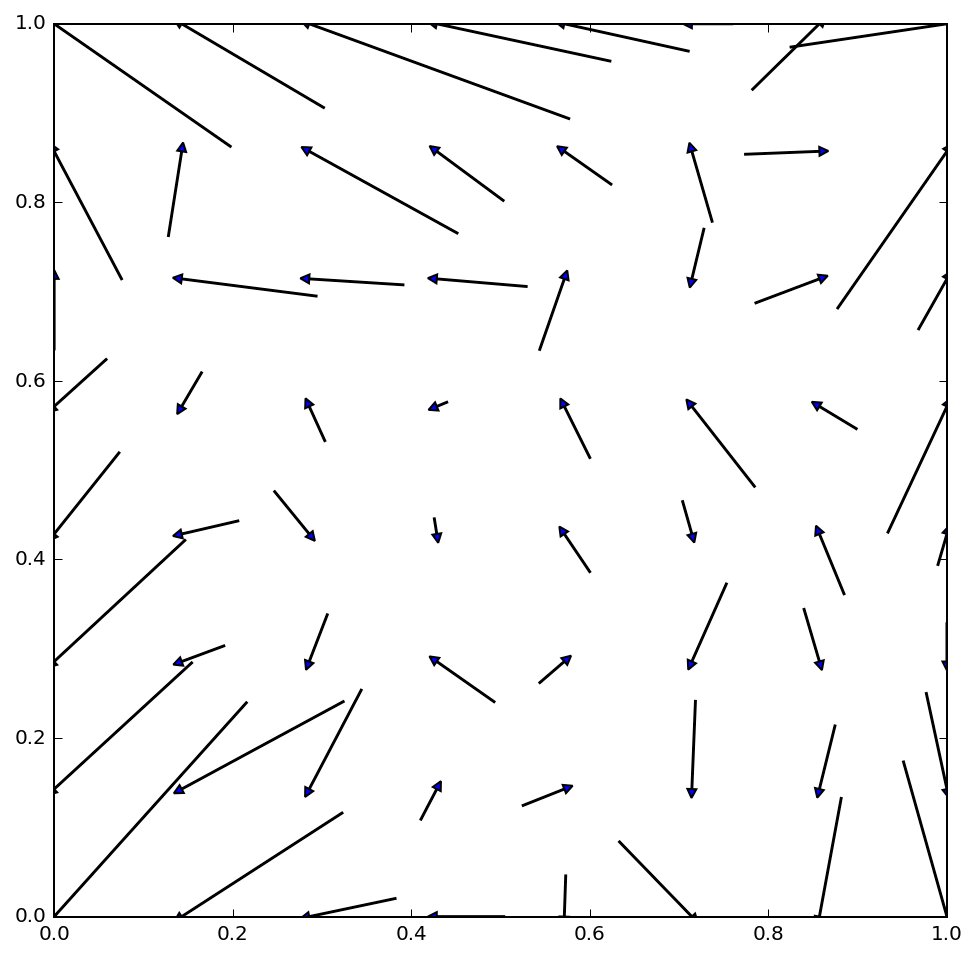

In [5]:
def square_memory_cloud_to_cloud(cloud_a, cloud_b):
    cost = cdist(cloud_a, cloud_b, 'sqeuclidean')
#     cost = cost * (100000. / cost.max()) # this is very common to keep the algorithm from failing
    lap_cost, row_assigns, col_assigns, u, v = lap(cost)
    return cloud_b[row_assigns], row_assigns

def square_memory_cloud_to_grid(data2d):
    n = len(data2d)
    side = np.sqrt(n)
    grid = make_grid(side)
    return square_memory_cloud_to_cloud(data2d, grid)

square_memory_grid, square_memory_assigns = square_memory_cloud_to_grid(data2d)
plt.figure(figsize=(8, 8))
plot_arrows(data2d, square_memory_grid)
plt.show()

Here's our linear memory version, which does a distance calculation whenever it is needed instead of in advance.

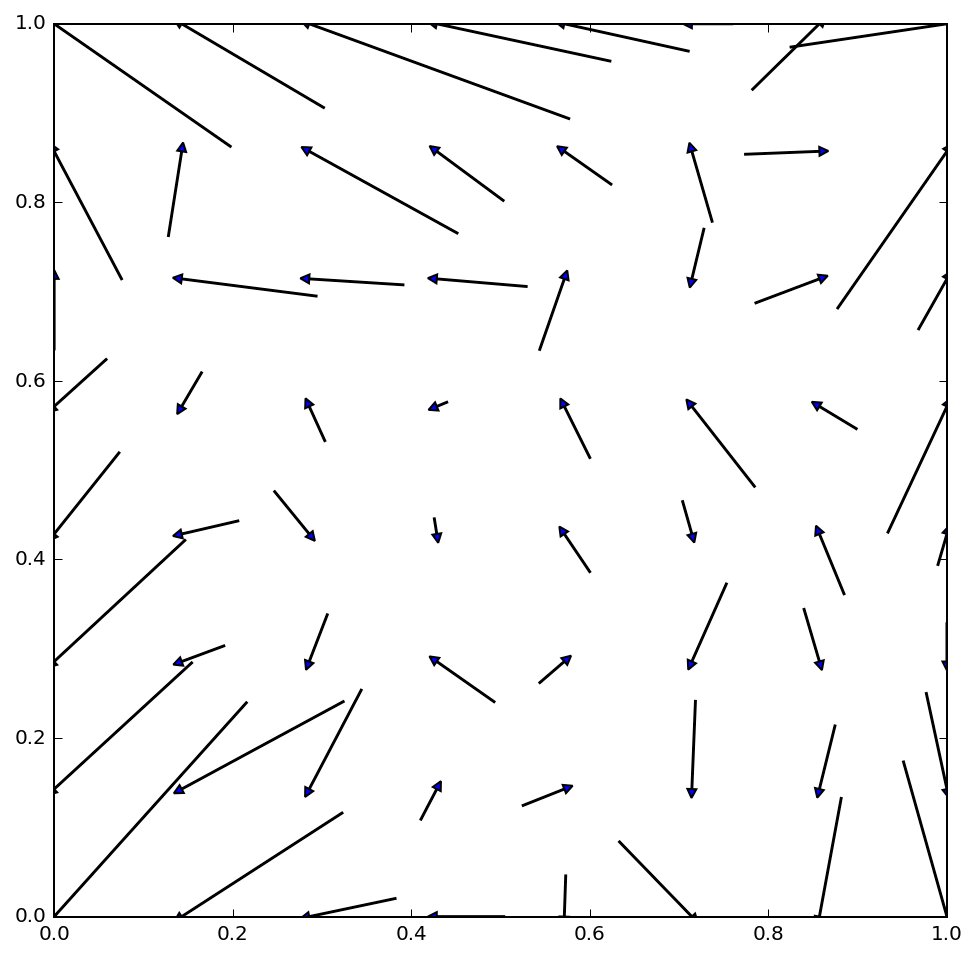

In [6]:
class PointCost:
    def __init__(self, a, b):
        assert len(a) == len(b), "len(a) = {} does not equal len(b) = {}".format(len(a), len(b))
        self.a = a
        self.b = b
    def __len__(self):
        return len(self.a)
    def __getitem__(self, ij):
        i, j = ij
        pa = self.a[i]
        pb = self.b[j]
        dx = pb[0] - pa[0]
        dy = pb[1] - pa[1]
        dx *= dx
        dy *= dy
        return dx + dy # assumes sqeuclidean
    
def linear_memory_cloud_to_cloud(cloud_a, cloud_b):
    cost = PointCost(cloud_a, cloud_b)
    lap_cost, row_assigns, col_assigns, u, v = lap(cost)
    return cloud_b[row_assigns], row_assigns

def linear_memory_cloud_to_grid(data2d):
    n = len(data2d)
    side = np.sqrt(n)
    grid = make_grid(side)
    return linear_memory_cloud_to_cloud(data2d, grid)

linear_memory_grid, linear_memory_assigns = linear_memory_cloud_to_grid(data2d)
plt.figure(figsize=(8, 8))
plot_arrows(data2d, linear_memory_grid)
plt.show()

Finally, we want to verify that the two assignments are equivalent.

In [7]:
print np.sum(square_memory_assigns == linear_memory_assigns) == totalDataPoints

True
